<a href="https://colab.research.google.com/github/daphoon/ASAC_05_DL_GGArt/blob/hoon/stable_diffusionv1_2_Test%26Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 테라로 우선 데이터셋 구축

In [ ]:
base_path = '/content/drive/MyDrive/1조/TextToImage/윤,소원 - 이미지 데이터셋'
tera_zip = base_path + '/tera데이터셋.zip'

In [ ]:
import zipfile
import os

# 압축을 해제할 디렉토리 생성
extract_path = '/content/extracted_files'
os.makedirs(extract_path, exist_ok=True)

# zip 파일 압축 해제
with zipfile.ZipFile(tera_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('압축 해제 완료:', os.listdir(extract_path))

압축 해제 완료: ['tera1']


# v1-2 모델 Usage

In [ ]:
!pip install --upgrade diffusers transformers scipy

### 테스트

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-2"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)
prompt = "a photo of an astronaut riding a horse on mars"
with autocast("cuda"):
  image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")

  0%|          | 0/50 [00:00<?, ?it/s]

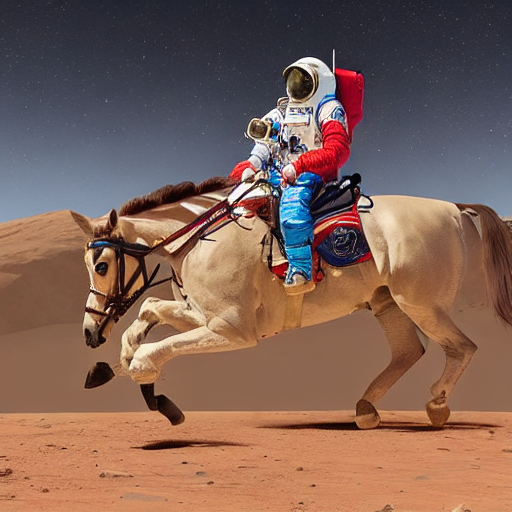

In [ ]:
from PIL import Image

Image.open("astronaut_rides_horse.png")

In [ ]:
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler

model_id = "CompVis/stable-diffusion-v1-2"
# Use the K-LMS scheduler here instead
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, use_auth_token=True)
pipe = pipe.to("cuda")


In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5).images[0]

image.save("astronaut_rides_horse.png")

  0%|          | 0/50 [00:00<?, ?it/s]

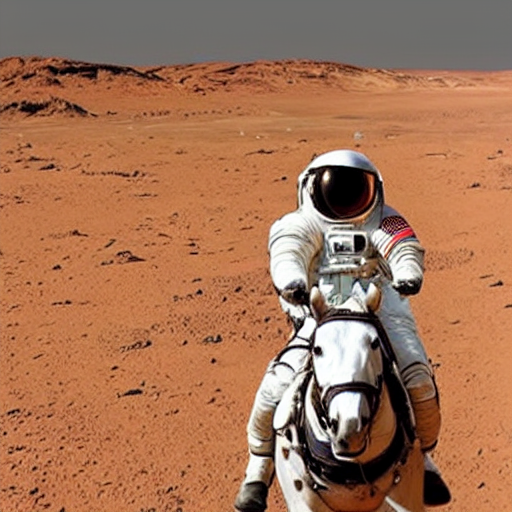

In [ ]:
Image.open("astronaut_rides_horse.png")

# Train 코드 작성

## Dataset 구축

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/1조/TextToImage/윤,소원 - 이미지 데이터셋/all_images_caption.csv', encoding='cp949')
df

In [ ]:
df[df['file_name'] == 'tera1.png']
## 학습 데이터를 확인하니, 캐릭터에 대한 묘사 뿐만 아니라 배경에 대한 정보도 같이 captioning 된다.

,file_name,caption
85,tera1.png,"The character has long, wavy silver hair casca..."


#### 테스트

In [ ]:
df_filtered = df[df['file_name'].str.contains('tera', case=False, na=False)]

In [ ]:
df_filtered.reset_index(drop=True, inplace=True)

In [ ]:
df_filtered.sort_values(by='filename', inplace=True)

<ipython-input-34-fc40ba55067f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by='filename', inplace=True)


In [ ]:
df_filtered.head()

,filename,caption
39,tera1.png,"The character has long, wavy silver hair casca..."
38,tera10.png,An elderly character with a hunched back and e...
37,tera13.png,"A tall, elven character with pale skin stands ..."
36,tera14.png,"A fierce, female elf warrior with white flowin..."
35,tera15.png,"""An agile elven warrior with long, flowing whi..."


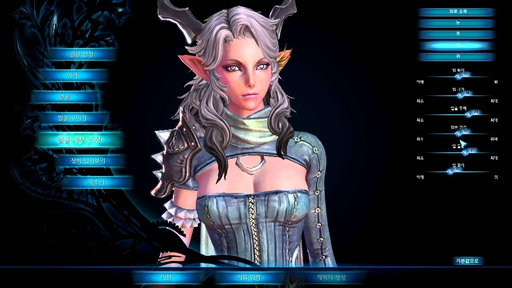

In [ ]:
## 이미지 형태 확인
Image.open('/content/extracted_files/tera1/tera1.png')

### 모델 config 설정

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import AutoTokenizer

class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir, dataframe, tokenizer_name="bert-base-uncased", transform=None):
        self.image_dir = image_dir
        self.dataframe = dataframe
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        self.caption_dict = {row['file_name']: row['caption'] for _, row in dataframe.iterrows()}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        file_name = self.image_files[idx]
        caption = self.caption_dict[file_name]
        image_path = os.path.join(self.image_dir, file_name)

        # Load image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        tokens = self.tokenizer(caption, return_tensors='pt', padding='max_length', truncation=True, max_length=77)

        return image, tokens.input_ids.squeeze(), tokens.attention_mask.squeeze()

# 데이터프레임이 'df'라는 변수에 저장되어 있다고 가정합니다.
dataset = ImageCaptionDataset(image_dir='/content/extracted_files', dataframe=df)

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
!git clone https://github.com/huggingface/diffusers
!cd diffusers
!pip install ./diffusers/.

Cloning into 'diffusers'...
remote: Enumerating objects: 66174, done.
remote: Counting objects: 100% (15854/15854), done.
remote: Compressing objects: 100% (1874/1874), done.
remote: Total 66174 (delta 14943), reused 14174 (delta 13890), pack-reused 50320
Receiving objects: 100% (66174/66174), 46.12 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (49113/49113), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2443627 sha256=acd24e4a614f2a0a53c7214d50cc423069cf065e6e09568f4a0e23d3b8f3c318
  Stored in directory: /tmp/pip-ephem-wheel-cache-fjfdfz3t/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


In [ ]:
!pip install -r ./diffusers/examples/text_to_image/requirements.txt

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install xformers

In [ ]:
# !export MODEL_NAME=
# !export dataset_name=

!accelerate launch /content/diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="lambdalabs/naruto-blip-captions" \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=16 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=1000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --enable_xformers_memory_efficient_attention \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir="sd-naruto-model" \
  --push_to_hub --hub_model_id='sdnarutomodel'

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipeline = StableDiffusionPipeline.from_pretrained("/content/sd-naruto-model", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

image = pipeline(prompt="yoda").images[0]
image.save("yoda-naruto.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

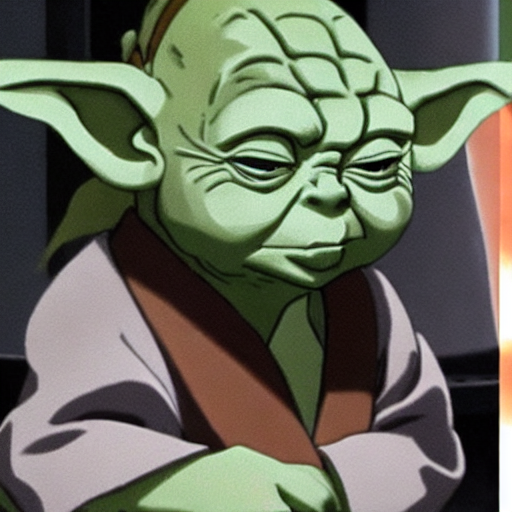

In [ ]:
from PIL import Image
Image.open("yoda-naruto.png")

In [ ]:
from shutil import copyfile
import os

In [ ]:
import shutil
# Step 2: 로컬 폴더와 Google Drive 목적지 설정
local_folder = '/content/sd-naruto-model'  # 옮길 로컬 폴더 경로
drive_folder = '/content/drive/MyDrive/target_folder'  # Google Drive 내 목적지 폴더 경로

# 목적지 폴더가 없으면 생성
if not os.path.exists(drive_folder):
    os.makedirs(drive_folder)

# Step 3: 폴더의 모든 파일을 Google Drive로 복사
for filename in os.listdir(local_folder):
    src_path = os.path.join(local_folder, filename)
    dst_path = os.path.join(drive_folder, filename)
    if os.path.isfile(src_path):
        shutil.copy(src_path, dst_path)

    elif os.path.isdir(src_path):
        shutil.copytree(src_path, dst_path)

print("폴더가 Google Drive로 성공적으로 옮겨졌습니다.")

폴더가 Google Drive로 성공적으로 옮겨졌습니다.


# Text to image 기초 Train 실습